In [17]:
# Cell 1: Import libraries (with warnings suppressed)

import warnings
import logging

# Suppress warnings from libraries
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.sklearn.metrics import disparate_impact_ratio

from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate

import os
import urllib.request


In [18]:
# Cell 2: Download the COMPAS dataset if not present

try:
    base_dir = os.path.dirname(__file__)
except NameError:
    base_dir = os.getcwd()  # Fallback for Jupyter

data_path = os.path.join(base_dir, 'data', 'raw', 'compas')
file_path = os.path.join(data_path, 'compas-scores-two-years.csv')

if not os.path.exists(file_path):
    os.makedirs(data_path, exist_ok=True)
    print("Downloading COMPAS dataset...")
    url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
    urllib.request.urlretrieve(url, file_path)
    print("Download complete.")


In [19]:
# Cell 3: Load and split the dataset

dataset_orig = CompasDataset()

# Split into training and testing sets (80% train, 20% test)
train, test = dataset_orig.split([0.8], shuffle=True)


In [20]:
# Cell 4: Train baseline Logistic Regression model

X_train, y_train = train.features, train.labels.ravel()
X_test, y_test = test.features, test.labels.ravel()

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [21]:
# Cell 5: Evaluate baseline model accuracy

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))


Baseline Accuracy: 0.6620745542949756


In [22]:
# Cell 6: Prepare predictions for fairness evaluation

pred_dataset = test.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(test, pred_dataset,
                               privileged_groups=[{'race': 1}],
                               unprivileged_groups=[{'race': 0}])

print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())


Disparate Impact: 0.8374427703321401
Equal Opportunity Difference: -0.05930740422802272


In [23]:
# Cell 7: Apply Reweighing preprocessing to mitigate bias

RW = Reweighing(unprivileged_groups=[{'race': 0}],
                privileged_groups=[{'race': 1}])
train_rw = RW.fit_transform(train)


In [24]:
# Cell 8: Train Logistic Regression model with reweighed data

clf_rw = LogisticRegression(max_iter=1000)
clf_rw.fit(train_rw.features, train_rw.labels.ravel(), sample_weight=train_rw.instance_weights)
y_pred_rw = clf_rw.predict(X_test)


In [25]:
# Cell 9: Evaluate reweighing model accuracy and fairness

rw_dataset = test.copy()
rw_dataset.labels = y_pred_rw.reshape(-1, 1)
metric_rw = ClassificationMetric(test, rw_dataset,
                                 privileged_groups=[{'race': 1}],
                                 unprivileged_groups=[{'race': 0}])

print("\nReweighing Accuracy:", accuracy_score(y_test, y_pred_rw))
print("Disparate Impact:", metric_rw.disparate_impact())
print("Equal Opportunity Difference:", metric_rw.equal_opportunity_difference())



Reweighing Accuracy: 0.6547811993517018
Disparate Impact: 1.0476718403547671
Equal Opportunity Difference: 0.06822190987387633


In [26]:
# Cell 10: Apply Reject Option Classification post-processing

ROC = RejectOptionClassification(unprivileged_groups=[{'race': 0}],
                                 privileged_groups=[{'race': 1}])
ROC = ROC.fit(test, pred_dataset)
preds_post = ROC.predict(pred_dataset)


In [27]:
# Cell 11: Evaluate post-processed model accuracy and fairness

metric_post = ClassificationMetric(test, preds_post,
                                   privileged_groups=[{'race': 1}],
                                   unprivileged_groups=[{'race': 0}])

print("\nReject Option Accuracy:", accuracy_score(y_test, preds_post.labels))
print("Disparate Impact:", metric_post.disparate_impact())
print("Equal Opportunity Difference:", metric_post.equal_opportunity_difference())



Reject Option Accuracy: 1.0
Disparate Impact: 0.8361419068736141
Equal Opportunity Difference: 0.0


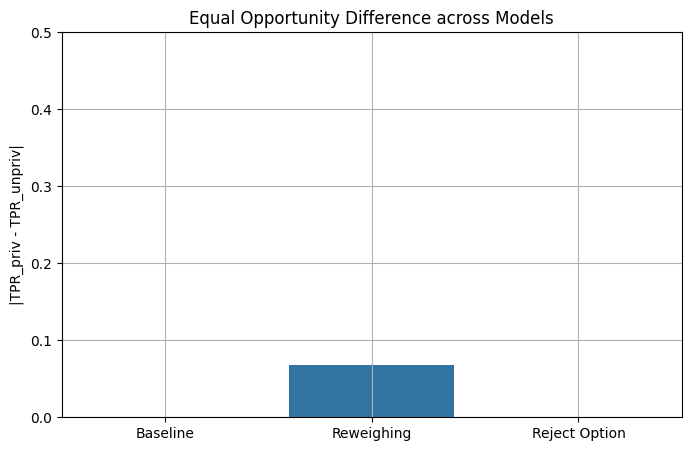

In [28]:
# Cell 12: Visualize Equal Opportunity Differences across models

labels = ['Baseline', 'Reweighing', 'Reject Option']
eod = [metric.equal_opportunity_difference(),
       metric_rw.equal_opportunity_difference(),
       metric_post.equal_opportunity_difference()]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=eod)
plt.title("Equal Opportunity Difference across Models")
plt.ylabel("|TPR_priv - TPR_unpriv|")
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()
